In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix,classification_report,
roc_curve, auc, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def obtener_importancias_y_features(pipeline_entrenado):
    # Si tiene SMOTE, entra al pipeline interno
    if 'smote' in pipeline_entrenado.named_steps:
        modelo = pipeline_entrenado.named_steps['modelo']
        preprocesador = pipeline_entrenado.named_steps['preprocesador']
    else:
        modelo = pipeline_entrenado.named_steps['modelo']
        preprocesador = pipeline_entrenado.named_steps['preprocesador']

    # Obtener nombres de features procesadas
    try:
        feature_names = preprocesador.get_feature_names_out()
    except:
        # Si falla, intenta construirlos manualmente
        feature_names = []
        if hasattr(preprocesador, 'transformers_'):
            for name, trans, cols in preprocesador.transformers_:
                if hasattr(trans, 'get_feature_names_out'):
                    nombres = trans.get_feature_names_out(cols)
                else:
                    nombres = cols
                feature_names.extend(nombres)

    # Obtener importancias según el tipo de modelo
    if hasattr(modelo, 'get_feature_importance'):
        importancias = modelo.get_feature_importance()
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
    else:
        raise AttributeError("El modelo no tiene atributo de importancia disponible.")

    return modelo, importancias, feature_names
def mostrar_importancias(modelo_nombre, importancias, features, top_n=15):
    df = pd.DataFrame({
        'Característica': features,
        'Importancia': importancias
    }).sort_values(by='Importancia', ascending=False)

    print(f"\n{'='*60}")
    print(f"🔹 Top {top_n} características más importantes - {modelo_nombre}")
    print(f"{'='*60}")
    print(df.head(top_n).to_string(index=False))

    # Gráfico
    plt.figure(figsize=(14, 10))
    plt.barh(df['Característica'][:top_n][::-1],
             df['Importancia'][:top_n][::-1])
    plt.title(f'Top {top_n} características más importantes - {modelo_nombre}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()

In [ ]:
class MultiHotDeckImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputations, random_state=0):
        self.imputations = imputations
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        rng = np.random.default_rng(self.random_state)
        for col, group in self.imputations:
            out = X[col].copy()
            for g, sub in X.groupby(group):
                pool = sub[col].dropna().to_numpy()
                idx = sub.index[sub[col].isna()]
                if pool.size > 0 and len(idx) > 0:
                    out.loc[idx] = rng.choice(pool, size=len(idx), replace=True)
            X[col] = out
        return X

In [ ]:
df1 = pd.read_csv("adult.data", header=None, na_values=["?", " ?"], skipinitialspace=True)
df2 = pd.read_csv("adult.test", header=None, na_values=["?", " ?"], skipinitialspace=True, skiprows=1)

In [ ]:
cols = [
        "Age", "Workclass", "Fnlwgt", "Education", "Education-num",
        "Marital-status", "Occupation", "Relationship", "Race", "Sex",
        "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"
    ]
df1.columns = cols
df2.columns = cols

In [ ]:
df1["Education-num"] = df1["Education-num"].astype("category")
df1["Income"] = df1["Income"].apply(lambda x: 1 if str(x).strip().startswith(">50K") else 0)
df1["Income"] = df1["Income"].astype("category")
df2["Education-num"] = df2["Education-num"].astype("category")
df2["Income"] = df2["Income"].apply(lambda x: 1 if str(x).strip().startswith(">50K") else 0)
df2["Income"] = df2["Income"].astype("category")

In [ ]:
X_train=df1.drop(['Income','Education-num'],axis=1)
y_train=df1['Income']
X_test=df2.drop(['Income','Education-num'],axis=1)
y_test=df2['Income']

## Preprocesamiento de datos

In [ ]:
num = X_train.select_dtypes(include=[np.number]).columns
cat = X_train.select_dtypes(include=['object','category']).columns

In [ ]:
cols=['Workclass','Occupation','Native-country']

In [ ]:
#Pipeline Categorico
Pipe_cat = Pipeline(steps=[
    ('hotdeck', MultiHotDeckImputer([
        ('Workclass', 'Education'),
        ('Occupation', 'Native-country')
    ])),
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

In [ ]:
#pipeline numerico
Pipe_num=Pipeline(steps=[
    ('scaler', StandardScaler()) 
    ])

In [ ]:
#Preprocesamiento mediante column transformer 
preprocesador = ColumnTransformer(
    transformers=[
        ('num', Pipe_num,num),
        ('cat', Pipe_cat, cat)
    ]
)

In [ ]:
#Pipeline Principal con preprocesamiento y modelo
Pipe = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', RandomForestClassifier())
])

In [ ]:
Pipe_cat_impute = Pipeline(steps=[
    ('hotdeck', MultiHotDeckImputer([
        ('Workclass', 'Education'),
        ('Occupation', 'Native-country')
    ])),
    ("imputer", SimpleImputer(strategy='most_frequent'))
])

In [ ]:
modelo=Pipe.fit(X_train,y_train)

In [ ]:
X_train_cat = X_train[cat]

In [ ]:
X_train_imputado= Pipe_cat_impute.fit_transform(X_train_cat)
X_train_imputado = pd.DataFrame(X_train_imputado, columns=X_train_cat.columns)

In [ ]:
for col in X_train_cat.columns:
    orig_counts = X_train[col].value_counts()
    imp_counts = X_train_imputado[col].value_counts()
    cats = orig_counts.index.union(imp_counts.index)
    contingency = np.array([
        orig_counts.reindex(cats, fill_value=0),
        imp_counts.reindex(cats, fill_value=0)
    ])
    stat, p, *_ = chi2_contingency(contingency)
    print(f"{col}: p-value = {p:.4f}")

Workclass: p-value = 0.9998
Education: p-value = 1.0000
Marital-status: p-value = 1.0000
Occupation: p-value = 1.0000
Relationship: p-value = 1.0000
Race: p-value = 1.0000
Sex: p-value = 1.0000
Native-country: p-value = 1.0000


# Evaluacion de metricas

## Modelo normal

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[11526   909]
 [ 1504  2342]]


In [ ]:
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.72      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



In [ ]:
scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision ": precision_score(y_test, y_pred),
    "Recall ": recall_score(y_test, y_pred),
    "F1-score ": f1_score(y_test, y_pred)
}

scores_df = pd.DataFrame(scores, index=["Score"])
print("\nTabla de métricas globales:\n")
print(scores_df)


Tabla de métricas globales:

       Accuracy  Precision    Recall   F1-score 
Score   0.85179    0.720394  0.608944   0.659997


In [ ]:
y_prob = Pipe.predict_proba(X_test)[:, 1]

AUC: 0.9004909251456508


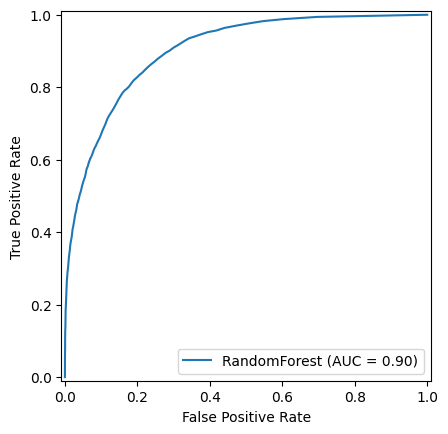

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="RandomForest").plot()
plt.show()

## Modelo balanceado

In [ ]:
Pipe_bal = ImbPipeline(steps=[
    ('preprocesador', preprocesador),
    ("smote", SMOTE(random_state=0)),
    ('modelo', RandomForestClassifier())
])

In [ ]:
modelo_bal=Pipe_bal.fit(X_train,y_train)

In [ ]:
y_pred_bal = modelo_bal.predict(X_test)

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

Confusion Matrix:
 [[11107  1328]
 [ 1224  2622]]


In [ ]:
print("Classification report:\n", classification_report(y_test, y_pred_bal))

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     12435
           1       0.66      0.68      0.67      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.79      0.78     16281
weighted avg       0.84      0.84      0.84     16281



In [ ]:
scores_bal = {
    "Accuracy": accuracy_score(y_test, y_pred_bal),
    "Precision ": precision_score(y_test, y_pred_bal),
    "Recall ": recall_score(y_test, y_pred_bal),
    "F1-score ": f1_score(y_test, y_pred_bal)
}

scores_df2 = pd.DataFrame(scores_bal, index=["Score"])
print("\nTabla de métricas globales:\n")
print(scores_df2)


Tabla de métricas globales:

       Accuracy  Precision    Recall   F1-score 
Score  0.843253    0.663797  0.681747   0.672653


In [ ]:
y_prob_bal = Pipe_bal.predict_proba(X_test)[:, 1]

AUC: 0.8972890230446371


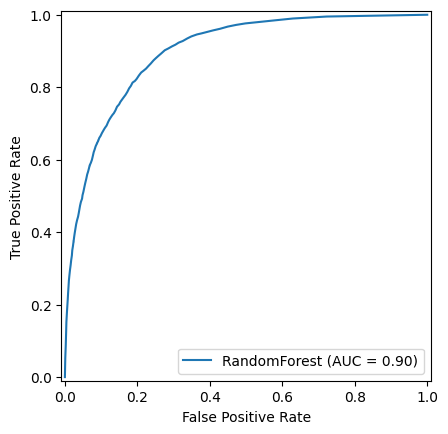

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bal)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="RandomForest").plot()
plt.show()

## Gridsearch para el modelo

In [ ]:
param_grid_rf = {
    'modelo__n_estimators': [200, 400],
    'modelo__max_depth': [10, 20, None],
    'modelo__min_samples_split': [2, 5],
    'modelo__min_samples_leaf': [1, 2],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__bootstrap': [True],
    'modelo__criterion': ['gini', 'entropy']
}

In [ ]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

In [ ]:
grid_search = GridSearchCV(
    estimator=Pipe_bal,
    param_grid=param_grid_rf,
    scoring='roc_auc',        
    cv=cv
)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocesador',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Fnlwgt', 'Capital-gain', 'Capital-loss', 'Hours-per-week'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('hotdeck',
                                                                                          MultiHotDeckImputer(imputatio...
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=0)),
                                       ('modelo', RandomForestClassifier())]),
             param_grid={'modelo__bootstrap': [True],
                         'modelo__criterion': ['gini', 'entropy'],
                         'modelo__max_depth': [10, 20, None],
                         'modelo__max_features': ['sqrt', 'log2'],
                         'modelo__min_samples_leaf': [1, 2],
                         'modelo__min_samples_split': [2, 5],
                         'modelo__n_estimators': [200, 400]},
             scoring='roc_auc')

In [ ]:
print(" Mejores parámetros:", grid_search.best_params_)
print(" Mejor ROC:", grid_search.best_score_)

 Mejores parámetros: {'modelo__bootstrap': True, 'modelo__criterion': 'entropy', 'modelo__max_depth': None, 'modelo__max_features': 'sqrt', 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 400}
 Mejor ROC: 0.9135156872797182


In [ ]:
y_pred_grid=grid_search.predict(X_test)

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_grid))

Confusion Matrix:
 [[10679  1756]
 [  862  2984]]


In [ ]:
print("Classification report:\n", classification_report(y_test, y_pred_grid))

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89     12435
           1       0.63      0.78      0.70      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.82      0.79     16281
weighted avg       0.86      0.84      0.84     16281



In [ ]:
scores_grid = {
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision ": precision_score(y_test, y_pred_grid),
    "Recall ": recall_score(y_test, y_pred_grid),
    "F1-score ": f1_score(y_test, y_pred_grid)
}

scores_df3 = pd.DataFrame(scores_grid, index=["Score"])
print("\nTabla de métricas globales:\n")
print(scores_df3)


Tabla de métricas globales:

       Accuracy  Precision    Recall   F1-score 
Score  0.839199    0.629536  0.775871   0.695085


In [ ]:
y_proba_grid = grid_search.predict_proba(X_test)[:, 1]

AUC: 0.9130673156158252


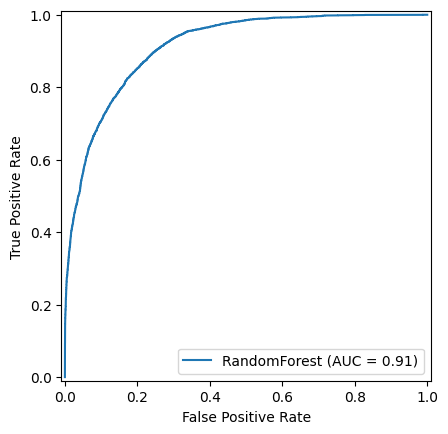

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_grid)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="RandomForest").plot()
plt.show()

## Feature importance

In [ ]:
preprocesador = Pipe_bal.named_steps["preprocesador"]

# Columnas numéricas después del escalado
num_features = preprocesador.transformers_[0][2]

# Columnas categóricas después del OneHotEncoder
cat_pipeline = preprocesador.named_transformers_["cat"]
ohe = cat_pipeline.named_steps["onehot"]
cat_features = ohe.get_feature_names_out(cat_pipeline.named_steps["imputer"].get_feature_names_out())

# Nombres finales de todas las features
feature_names = np.concatenate([num_features, cat_features])

In [ ]:
modelo_rf = grid_search.best_estimator_.named_steps["modelo"]

In [ ]:
importancias = modelo_rf.feature_importances_
df_importancias = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importancias
}).sort_values(by="Importance", ascending=False)

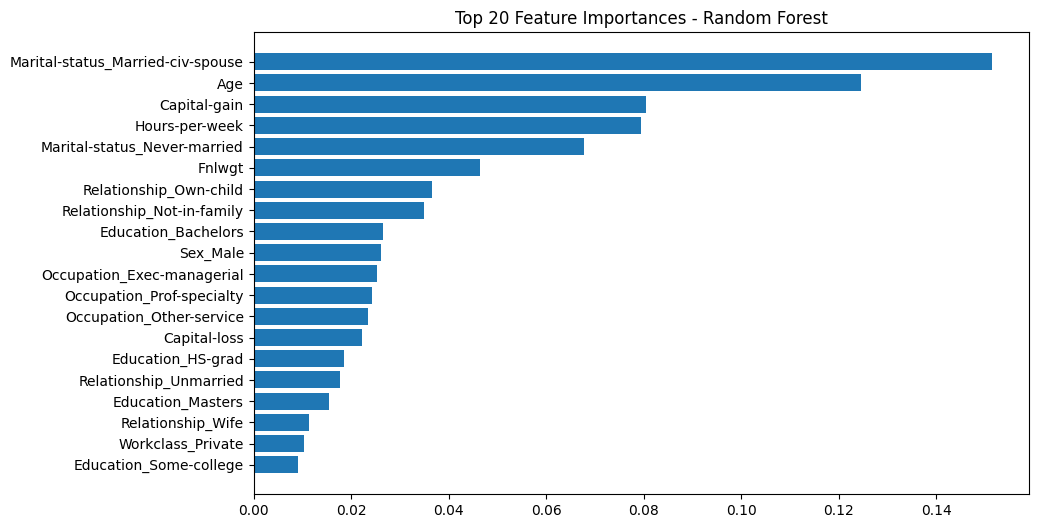

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(df_importancias["Feature"][:20], df_importancias["Importance"][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Exportacion del modelo

In [ ]:
cm=confusion_matrix(y_test, y_pred_grid)
fpr, tpr, _ = roc_curve(y_test, y_proba_grid)
roc_auc = auc(fpr, tpr)

In [ ]:
np.savez("modelo/results_rf.npz", cm=cm, fpr=fpr, tpr=tpr, roc_auc=roc_auc)

In [ ]:
joblib.dump(grid_search, "modelo/gridsearch_rf.joblib",compress=3)

['modelo/gridsearch_rf.joblib']